# Market Movement Prediction<br>
The notebook will use a few classification techniques to predict market movement. The base case might be a random walk or logistic regression and alternate will be to use either a boosting technique and/or random forest.<br>

Market movement is definined by simply looking at the magnitude of the return. That is if a return is positive, the label is 1, and 0 otherwise. <br>

Time permitting I may look at configurations of this definition. For example direction difined by movent over the following hour - an aggregate of the windows 5 minute returns, as an example.

In [2]:
import json, requests
import pandas as pd
import numpy as np
import io
import random
import time

from random import sample

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
#!pip install yfinance

  # Libraries for stock data
import yfinance as yf

## Data Gathering

**Get list of S&P stocks**

In [6]:
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
tckr = table[0]
tckr.to_csv('S&P500-Info.csv')
tckr.to_csv("S&P500-Symbols.csv", columns=['Symbol'])
# convert to list
basket = tckr.Symbol.unique().tolist()

In [7]:
bkt_40 = sample(basket,40)

In [8]:
bkt_40[:10]

['VFC', 'HAL', 'TJX', 'SWKS', 'AIG', 'MTD', 'WRK', 'GLW', 'FSLR', 'DXC']

**Functions**

In [9]:
def stock_data_pull(basket,verb=True):
  """
  Download Stock data
  """
  stock_final = pd.DataFrame()
  # iterate over each symbol
  for i in basket:  
      
      # print the symbol which is being downloaded
      if verb:
        print( str(basket.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)  
      
      try:
          # download the stock price 
          stock = []
          #stock = yf.download(i,period = "2y",interval='5m', progress=False)
          # for intraday yahoo finance only let's you pull past 60 days. 
          # however there is only a 1 month option
          stock = yf.download(i,period = "1mo",interval='5m', progress=False)

          # append the individual stock prices 
          if len(stock) == 0:
              None
          else:
              stock['Name']=i
              stock_final = stock_final.append(stock,sort=False)
      except Exception:
          None
  stock_final.reset_index(inplace=True)
  # return dataframe with only key columns: 'Datetime','Close','Volume','Name' 
  stock_final = stock_final[['Datetime','Close','Volume','Name']].copy()
  return stock_final

#def fill_blanks(df,srl_num,range,value_variable,date_variable):
def fill_blanks(df,srl_num,range,date_variable):

  """
  fills missing observations
  some stocks may not have the same number of observations
  """
  stage_df = df.copy()
  for comb in stage_df[srl_num].unique(): 
    temp = stage_df[stage_df[srl_num] == comb].copy()
    stage_df = stage_df[stage_df[srl_num] != comb] # remove existing series detail
    temp2 = range.merge(temp,how='left',on=date_variable)
    # since we are filling missing data, other fields will be missing to
    # value info will be filled by zero, for other fields, we simply forward fill
    # Then back fill for full missing value coverage    
    temp2.fillna(method='ffill',inplace=True)
    temp2.fillna(method='bfill',inplace=True)
    # replace with new, full data subset
    stage_df = stage_df.append(temp2,ignore_index=True)
  return stage_df

In [10]:
def feature_create(df_in,tckr_list, window,lags,features,clip=False):
  """
  Takes in dataframe with stock information for a sinlge ticker. Returns
  df with return, volatility, momentum, sma, min, and max 
  """
  df_int = pd.DataFrame()

  # validate input data frame has equal number of observations per symbol
  sizes = df_in.groupby('Name').size().unique()
  size_count = sizes.shape[0]

  if size_count == 1:
    print (f'all good, all data contains {sizes[0]} observations')
  else:
    print(f'error, your stock contain tckrs with varying number of observations:{sizes}')
    return

  for tckr in tckr_list:
    temp = df_in[df_in["Name"] == tckr]
    temp.sort_values('Datetime', inplace=True)
    # create core features
    temp['return'] = np.log(temp.Close / temp.Close.shift(1))  
    temp['vol'] = temp['return'].rolling(window).std()      # measure of volatility
    temp['mom'] = np.sign(temp['return'].rolling(window).mean())  
    temp['sma'] = temp['Close'].rolling(window).mean()  
    temp['min'] = temp['Close'].rolling(window).min()  
    temp['max'] = temp['Close'].rolling(window).max()
    temp.dropna(inplace=True)
    # create lag variables
    cols = []
    for f in features:
      for lag in range(1, lags + 1):
        col = f'{f}_lag_{lag}'
        temp[col] = temp[f].shift(lag)  
        cols.append(col)
    print('size of temp is',temp.shape[0])
    if clip:
      # just take only last n, required observations
      temp = temp.tail(1)
      print('size of temp is after clipping',temp.shape[0])
    df_int = df_int.append(temp,ignore_index=True)
    #df_int = df_int.append(temp,ignore_index=True)

  df_int.dropna(inplace=True)
  ## Create lags after core feaures created inside of df_int

  df_int.dropna(inplace=True)

  df_int['direction'] = np.where(df_int['return'] > 0, 1, -1) 

  return df_int, cols

**End of Functions**

**Pull and clean data** <br>*for each stock symbol:*<br>1. Pull historical data.<br>2. Fil in missing intervals with forward and back fill.

In [12]:
stock_ready.head()

,Datetime,Close,Volume,Name
0,2022-12-09 12:25:00,28.344999,0.0,VFC
1,2022-12-09 12:30:00,28.395000,27430.0,VFC
2,2022-12-09 12:35:00,28.405001,53853.0,VFC
3,2022-12-09 12:40:00,28.381100,31890.0,VFC
4,2022-12-09 12:45:00,28.360001,22222.0,VFC


##Data Prep

**New Feature Creation**<br>
- For each tckr in basket
- Create a window variable that defines the rolling measure size
- create volume, sma, min, max for each stock


*code derived from 'Python for Algorithmic Trading', Yves Hilpisch*

In [13]:
# need to calculate metrics seperately for each tckr symbol
window = 20  
features = ['return', 'vol', 'mom', 'sma', 'min', 'max']  
lags = 6  

# call function to genereate all new variables
stk_rdy_2, cols =  feature_create(stock_ready,bkt_40, window,lags,features)

all good, all data contains 1483 observations
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463
size of temp is 1463


In [14]:
# Check the dimensions of resultant df
#stk_rdy_2.shape

# Check the numbe of ticker symbols 
#len(stk_rdy_2.Name.unique())

# Check that each ticker has the same number
# checks to ensure if all tckrs have same size
sizes = stk_rdy_2.groupby('Name').size().unique()
size_count = sizes.shape[0]
if size_count == 1:
  print (f'all good, all data contains {sizes[0]} observations')
else:
  print(f'error, your stock contain tckrs with varying number of observations:{sizes}')

all good, all data contains 1457 observations


In [15]:
stk_rdy_2.head()

,Datetime,Close,Volume,Name,return,vol,mom,sma,min,max,...,min_lag_4,min_lag_5,min_lag_6,max_lag_1,max_lag_2,max_lag_3,max_lag_4,max_lag_5,max_lag_6,direction
6,2022-12-09 14:35:00,28.455000,134864.0,VFC,0.001231,0.001417,1.0,28.38447,28.299999,28.495001,...,28.299999,28.299999,28.299999,28.495001,28.495001,28.469999,28.459400,28.415001,28.415001,1
7,2022-12-09 14:40:00,28.395000,93317.0,VFC,-0.002111,0.001504,1.0,28.38597,28.299999,28.495001,...,28.299999,28.299999,28.299999,28.495001,28.495001,28.495001,28.469999,28.459400,28.415001,-1
8,2022-12-09 14:45:00,28.430000,96940.0,VFC,0.001232,0.001519,1.0,28.38997,28.299999,28.495001,...,28.299999,28.299999,28.299999,28.495001,28.495001,28.495001,28.495001,28.469999,28.459400,1
9,2022-12-09 14:50:00,28.395000,48874.0,VFC,-0.001232,0.001550,1.0,28.39197,28.299999,28.495001,...,28.299999,28.299999,28.299999,28.495001,28.495001,28.495001,28.495001,28.495001,28.469999,-1
10,2022-12-09 14:55:00,28.344999,80200.0,VFC,-0.001762,0.001568,-1.0,28.38947,28.299999,28.495001,...,28.299999,28.299999,28.299999,28.495001,28.495001,28.495001,28.495001,28.495001,28.495001,-1


## Model Prep

Starting with binary prediction, but this could easily be exented to multi class yield predict - strong buy, buy, hold, sell, strong sell predictions.<br>

Later it would be good to include hyperparamter optimization using experiments.

**Train/Test Methodology**<br>
Test and train split is done slightly differently for development level model
typically a time series model, would split train/test along time horizon
in this case we will split along ticker symbols. So both test and train records will contain all time observations. For production model, with data that contains longer time span, this will be addressed, to avoid any potential data leakage.

**Model Train**<br>
random forest

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [17]:
# Parameter Set up
n_estimators=15
random_state=100  
max_depth=5
min_samples_leaf=15  

In [18]:
rf = RandomForestClassifier(random_state=random_state,
                                      max_depth=max_depth,
                                      min_samples_leaf=min_samples_leaf)  

bst_clf = HistGradientBoostingClassifier(random_state=random_state)

**Data train/test split**

In [19]:
train_list = sample(bkt_40, 30)
train = stk_rdy_2[stk_rdy_2.Name.isin(train_list)]
test = stk_rdy_2[~stk_rdy_2.Name.isin(train_list)]

# create test list for refereince later
test_list = test.Name.unique().tolist()

In [20]:
train.shape[0]/(train.shape[0]+test.shape[0])


0.75

In [21]:
# # define x and y
X_train = train[cols]
y_train = train['direction']
X_test = test[cols]
y_test = test['direction']

In [22]:
pipe_rf = make_pipeline(StandardScaler(), rf)

In [23]:
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=15,
                                        random_state=100))])

In [24]:
pipe_rf.score(X_train, y_train)

0.5504918782887211

In [25]:
pipe_rf.score(X_test, y_test)

0.5214824982841455

**Boosting Algo**

In [26]:
pipe_bclf = make_pipeline(StandardScaler(), bst_clf)

In [27]:
pipe_bclf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(random_state=100))])

In [28]:
pipe_bclf.score(X_train, y_train)

0.6405856783344772

In [29]:
pipe_bclf.score(X_test, y_test)

0.5249828414550446

**Plot Results**

In [30]:
test_set_df = test.copy()

In [38]:
test_set_df.head()

,Datetime,Close,Volume,Name,return,vol,mom,sma,min,max,...,max_lag_2,max_lag_3,max_lag_4,max_lag_5,max_lag_6,direction,rf_position,rf_strategy,boost_position,boost_strategy
2932,2022-12-09 14:35:00,77.980003,29476.0,TJX,0.001026,0.000999,1.0,77.827501,77.559998,78.000000,...,78.000000,78.000000,78.0,78.0,78.0,1,1,0.001026,-1,-0.001026
2933,2022-12-09 14:40:00,78.059998,30514.0,TJX,0.001025,0.001005,1.0,77.852501,77.610001,78.059998,...,78.000000,78.000000,78.0,78.0,78.0,1,-1,-0.001025,-1,-0.001025
2934,2022-12-09 14:45:00,78.175003,32898.0,TJX,0.001472,0.001036,1.0,77.880751,77.660004,78.175003,...,78.000000,78.000000,78.0,78.0,78.0,1,-1,-0.001472,-1,-0.001472
2935,2022-12-09 14:50:00,78.139999,24569.0,TJX,-0.000448,0.000949,1.0,77.898500,77.660004,78.175003,...,78.059998,78.000000,78.0,78.0,78.0,-1,-1,0.000448,-1,0.000448
2936,2022-12-09 14:55:00,78.180000,33621.0,TJX,0.000512,0.000898,1.0,77.922501,77.660004,78.180000,...,78.175003,78.059998,78.0,78.0,78.0,1,-1,-0.000512,-1,-0.000512


In [31]:
# pick tckr and apply filter
test_set_df['rf_position'] = pipe_rf.predict(test_set_df[cols])

In [32]:
test_set_df['rf_strategy'] = test_set_df['rf_position'] * test_set_df['return']

In [33]:
test_set_df['boost_position'] = pipe_bclf.predict(test_set_df[cols])

In [34]:
test_set_df['boost_strategy'] = test_set_df['boost_position'] * test_set_df['return']

In [35]:
test_set_df.Name.unique()

array(['TJX', 'FSLR', 'DXC', 'PM', 'AMCR', 'VICI', 'BBY', 'RL', 'WDC',
       'HD'], dtype=object)

In [39]:
temp_test = test_set_df[test_set_df['Name']=='AMCR']
temp_test.set_index('Datetime', inplace=True)

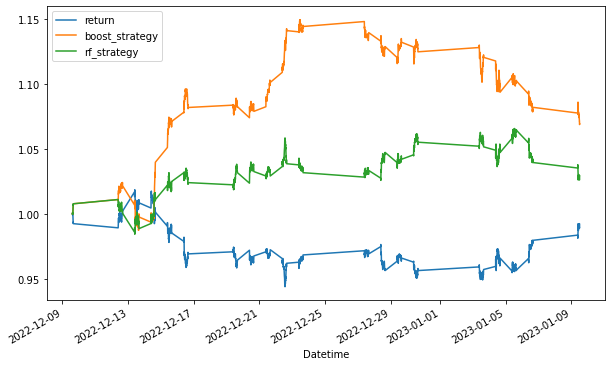

In [40]:
temp_test[['return', 'boost_strategy', 'rf_strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6));

#### Save the model

In [42]:
from joblib import dump, load

In [43]:
#!mkdir saved_models

In [44]:
# save model
#os.makedirs("models", exist_ok=True)

dump(pipe_rf, "saved_models/pipe_rf.joblib")
dump(pipe_bclf, "saved_models/pipe_bclf.joblib")

['saved_models/pipe_bclf.joblib']

**Overview of simulating realtime**
There are two components of this.
1. **New Streaming data** - will be simulated by slicing 26 observation window, passing it on. Then taking a stride of one observation and repeating 
2. **Pre processing newly presented data** Creates new features and produces input data for model

**First test functions that clip off last window + lags observations of data frame**

Create out of sample list to test hitting model

In [45]:
oos_bkt_list = sample(list(set(basket)-set(bkt_40)),10)
oos_bkt_list

['NVR', 'TER', 'MET', 'CTSH', 'KLAC', 'CSGP', 'ETN', 'IEX', 'AAPL', 'DAL']

In [46]:
stk_pull_2 = stock_data_pull(oos_bkt_list,False)

date_range = stk_pull_2.Datetime.drop_duplicates()
date_range = pd.DataFrame(date_range)
stock_ready_2 = fill_blanks(stk_pull_2,'Name',date_range,'Datetime');




In [47]:
# call function to genereate all new variables
stk_rdy_3, cols =  feature_create(stock_ready_2,oos_bkt_list, window,lags,features,clip=True)

all good, all data contains 1483 observations
size of temp is 1463
size of temp is after clipping 1
size of temp is 1463
size of temp is after clipping 1
size of temp is 1463
size of temp is after clipping 1
size of temp is 1463
size of temp is after clipping 1
size of temp is 1463
size of temp is after clipping 1
size of temp is 1463
size of temp is after clipping 1
size of temp is 1463
size of temp is after clipping 1
size of temp is 1463
size of temp is after clipping 1
size of temp is 1463
size of temp is after clipping 1
size of temp is 1463
size of temp is after clipping 1


In [48]:
stk_rdy_3.shape

(10, 47)

In [49]:
stk_rdy_3.columns

Index(['Datetime', 'Close', 'Volume', 'Name', 'return', 'vol', 'mom', 'sma',
       'min', 'max', 'return_lag_1', 'return_lag_2', 'return_lag_3',
       'return_lag_4', 'return_lag_5', 'return_lag_6', 'vol_lag_1',
       'vol_lag_2', 'vol_lag_3', 'vol_lag_4', 'vol_lag_5', 'vol_lag_6',
       'mom_lag_1', 'mom_lag_2', 'mom_lag_3', 'mom_lag_4', 'mom_lag_5',
       'mom_lag_6', 'sma_lag_1', 'sma_lag_2', 'sma_lag_3', 'sma_lag_4',
       'sma_lag_5', 'sma_lag_6', 'min_lag_1', 'min_lag_2', 'min_lag_3',
       'min_lag_4', 'min_lag_5', 'min_lag_6', 'max_lag_1', 'max_lag_2',
       'max_lag_3', 'max_lag_4', 'max_lag_5', 'max_lag_6', 'direction'],
      dtype='object')

In [73]:
stk_rdy_3.to_csv('test_model_input.csv',index=False)

In [51]:
result = pipe_bclf.predict(stk_rdy_3[cols])

In [54]:
input_example = stk_rdy_3[cols]

In [55]:
input_example.shape

(10, 36)

In [63]:
input_example.head()

,return_lag_1,return_lag_2,return_lag_3,return_lag_4,return_lag_5,return_lag_6,vol_lag_1,vol_lag_2,vol_lag_3,vol_lag_4,...,min_lag_3,min_lag_4,min_lag_5,min_lag_6,max_lag_1,max_lag_2,max_lag_3,max_lag_4,max_lag_5,max_lag_6
0,-0.002143,0.001164,0.000560,0.001890,-0.001429,0.000150,0.002161,0.002290,0.002280,0.002307,...,4795.140625,4795.140625,4795.140625,4799.000000,4820.000000,4828.270020,4828.270020,4828.270020,4828.270020,4828.270020
1,-0.002249,0.000314,0.000837,0.000314,0.001047,-0.000419,0.001329,0.001562,0.001652,0.001652,...,95.309998,95.129997,95.050003,95.044998,95.720001,95.779999,95.779999,95.779999,95.779999,95.779999
2,-0.000139,-0.000833,-0.000971,0.000139,-0.001178,-0.002144,0.000985,0.001016,0.001018,0.001014,...,72.059998,72.120003,72.120003,72.205002,72.660004,72.660004,72.660004,72.660004,72.660004,72.660004
3,-0.000327,0.001309,0.002296,0.002301,0.001317,0.000330,0.001410,0.001586,0.001569,0.001488,...,60.590000,60.590000,60.590000,60.590000,61.139999,61.139999,61.060001,61.040001,61.040001,61.040001
4,-0.000770,-0.000606,0.001026,-0.001991,0.001882,-0.000555,0.001360,0.001828,0.001876,0.001872,...,412.959991,412.959991,412.959991,412.959991,416.480011,416.739990,416.739990,416.739990,416.739990,416.739990


In [56]:
input_example.shape

(10, 36)

In [59]:
input_example_dict = input_example.to_dict('series')

In [61]:
input_example_dict.keys()

dict_keys(['return_lag_1', 'return_lag_2', 'return_lag_3', 'return_lag_4', 'return_lag_5', 'return_lag_6', 'vol_lag_1', 'vol_lag_2', 'vol_lag_3', 'vol_lag_4', 'vol_lag_5', 'vol_lag_6', 'mom_lag_1', 'mom_lag_2', 'mom_lag_3', 'mom_lag_4', 'mom_lag_5', 'mom_lag_6', 'sma_lag_1', 'sma_lag_2', 'sma_lag_3', 'sma_lag_4', 'sma_lag_5', 'sma_lag_6', 'min_lag_1', 'min_lag_2', 'min_lag_3', 'min_lag_4', 'min_lag_5', 'min_lag_6', 'max_lag_1', 'max_lag_2', 'max_lag_3', 'max_lag_4', 'max_lag_5', 'max_lag_6'])

In [60]:
input_example_dict.from_dict()

AttributeError: 'dict' object has no attribute 'from_dict'

In [53]:
result.shape

(10,)

In [74]:
cols

['return_lag_1',
 'return_lag_2',
 'return_lag_3',
 'return_lag_4',
 'return_lag_5',
 'return_lag_6',
 'vol_lag_1',
 'vol_lag_2',
 'vol_lag_3',
 'vol_lag_4',
 'vol_lag_5',
 'vol_lag_6',
 'mom_lag_1',
 'mom_lag_2',
 'mom_lag_3',
 'mom_lag_4',
 'mom_lag_5',
 'mom_lag_6',
 'sma_lag_1',
 'sma_lag_2',
 'sma_lag_3',
 'sma_lag_4',
 'sma_lag_5',
 'sma_lag_6',
 'min_lag_1',
 'min_lag_2',
 'min_lag_3',
 'min_lag_4',
 'min_lag_5',
 'min_lag_6',
 'max_lag_1',
 'max_lag_2',
 'max_lag_3',
 'max_lag_4',
 'max_lag_5',
 'max_lag_6']

In [75]:
result

array([-1,  1, -1, -1, -1,  1,  1, -1,  1, -1])

In [52]:
type(result)

numpy.ndarray

In [76]:
result.tolist()

[-1, 1, -1, -1, -1, 1, 1, -1, 1, -1]

Test running stocks above through all preprocessing and hitting the  model